# Atmósfera Y Clima

### Práctica 3: La teledetección como herramienta para la validación de modelos de cambio climático

        Javier Díez Sierra -Instituto de Física de Cantabria (IFCA-CSIC)- javier.diez@unican.es

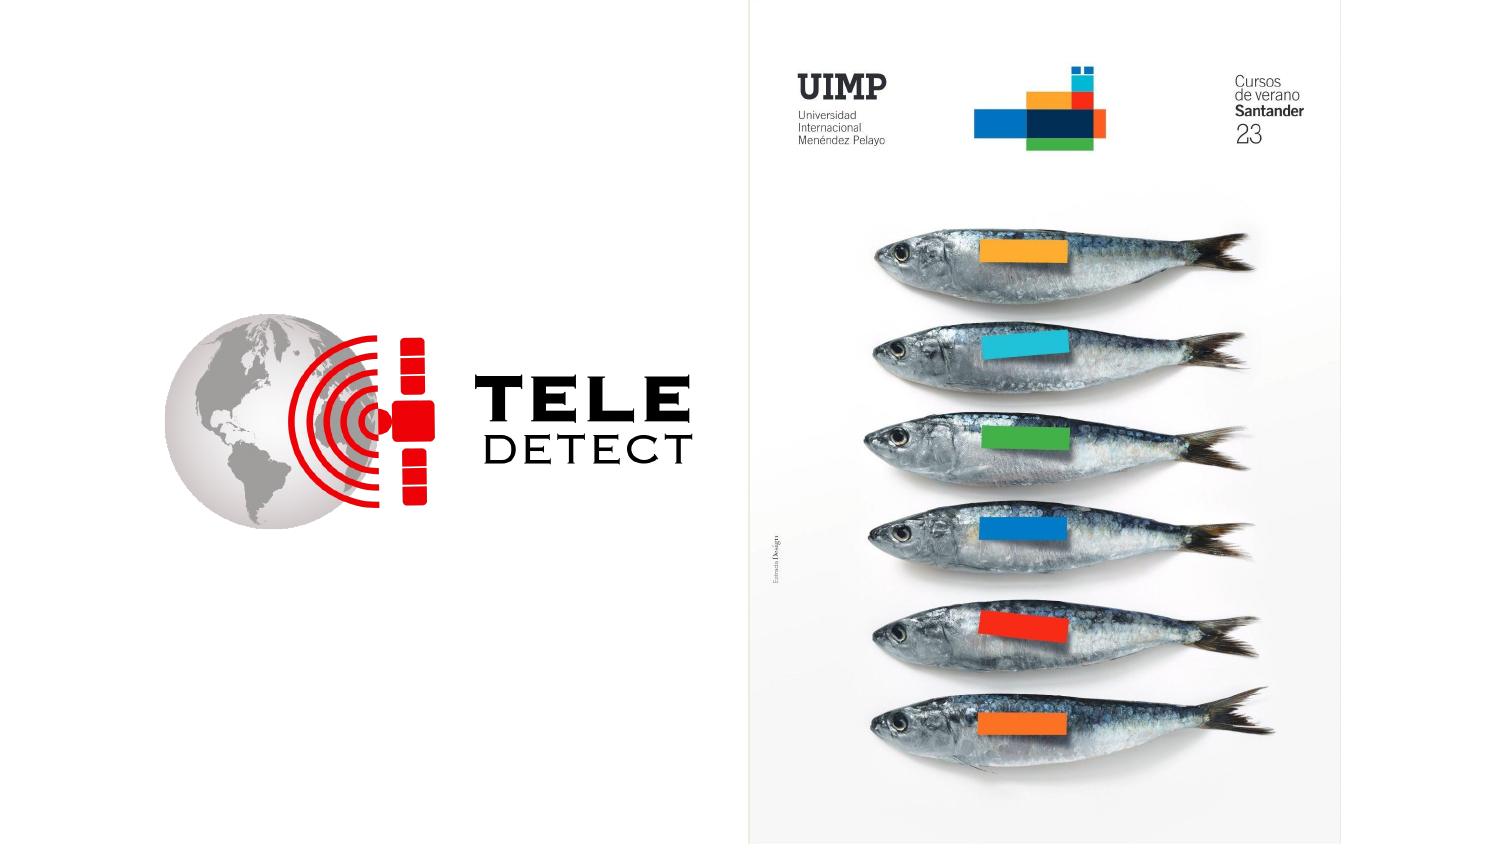

In [1]:
from IPython import display
display.Image("portada.png")

En este script vamos utilizar la base da datos de [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=overview) para **analizar la capacidad de los modelos CORDEX de cambio climático** del sexto informa del [IPCC](https://www.ipcc.ch/assessment-report/ar6/) para **reproducir las tendencias de temperatura observadas** en el periodo histórico. 

Para poder ejectura el script es necesario crear un enviroment de [conda](https://docs.conda.io/en/latest/) con los paquetes de python necesariso y crear un usuario en el Climate Data Store [CDS](https://cds.climate.copernicus.eu/) de Copernicus para la descarga de datos. A continuación, se describen los pasos a seguir:

- Descargar el instalador de conda o miniconda: [https://docs.conda.io/en/latest/miniconda.html](https://docs.conda.io/en/latest/miniconda.html)
- `conda create --name validation cdsapi xarray netcdf4 dask numpy pandas cartopy matplotlib scipy jupyter`(creamos el entorno de python)
- `conda activate validation` (activamos el entorno de python)
- `jupyter notebook` (abrimos el jupyter notebook)
- buscamos el script "08-PRACTICA_03.ipynb"

In [2]:
# load packages
import cdsapi
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import glob
import os
import sys
import random
from scipy import stats
from IPython import display

ModuleNotFoundError: No module named 'cdsapi'

In [3]:
# load some functions
def spatial_weighted_mean(ds):
    """Function to calculate weighted spatial mean"""
    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"
    ds_weighted = ds.weighted(weights)
    ds_weighted_mean = ds_weighted.mean(("lon", "lat")).compute()
    return ds_weighted_mean

def standardization(ds, lon_name = "longitude", lat_name = "latitude"):
    """Funtion for data standardization"""
    lon = ds[lon_name]
    ds[lon_name] = ds[lon_name].where(lon <= 180, other = lon - 360)
    ds = ds.reindex(**{lon_name: sorted(ds[lon_name])})
    ds = ds.reindex(**{lat_name: sorted(ds[lat_name])})
    if "longitude" in ds.dims or "longitude" in ds.coords:
        ds = ds.rename({"longitude": "lon", "latitude": "lat"}) 
    ## Change name variables
    if 't2m' in ds.variables:
        ds = ds.rename({'t2m': "tas"}) 
    return ds

def slope(y):
    """Calculate slopes"""
    # Wrapper around scipy linregress to use in apply_ufunc
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return np.array([slope, intercept, r_value, p_value, std_err])

def random_color_string(string_list):
    """Generate a list of random colors (same color same string)"""
    gcm_models = np.unique(string_list)
    number_of_colors = len(gcm_models)
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    color_list = []
    for gcm in string_list:
        posi = np.where(gcm_models == gcm)[0]
        color_list.append(color[posi[0]])
    return color_list

## Descarga de datos de ERA5 de Copernicus (C3S-CDS)

1- Crear usuario en el CDS (https://cds.climate.copernicus.eu/)

2- Generar fichero .cdsapirc (/home/javi/.cdsapirc)

3- Seleccionar catálogo (https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-pressure-levels-monthly-means?tab=overview)

In [4]:
dest = os.getcwd() + '/data/'
dest

'/home/javi/Docencia/2022-2023/Teledeteccion/scrips/data/'

In [7]:
variables = ['2m_temperature', 'total_precipitation']

YEARS = [str(y) for y in np.arange(1940, 2023)]

c = cdsapi.Client()

for variable in variables:
    for year in YEARS:
        # create directory
        os.makedirs(dest + 'ERA5/' + variable + '/', exist_ok=True)
        # download
        c.retrieve(
            'reanalysis-era5-single-levels-monthly-means',
            {
                'product_type': 'monthly_averaged_reanalysis',
                'variable': variable,
                'year': [year,],
                'month': ['01', '02', '03', 
                          '04', '05', '06',
                          '07', '08', '09', 
                          '10', '11', '12'],
                'time': '00:00',
                'format': 'netcdf',
            },
        dest + 'ERA5/' + variable + '/' + variable + '_' + year + '.nc' )
        if year == '1945':
            sys.exit()

2023-06-16 10:33:57,320 INFO Welcome to the CDS
2023-06-16 10:33:57,321 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-06-16 10:33:57,420 INFO Request is completed
2023-06-16 10:33:57,421 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data7/adaptor.mars.internal-1686557046.7755194-23181-6-1d008bc6-b238-4292-98c6-1b95fc006bee.nc to /home/javi/Docencia/2022-2023/Teledeteccion/scrips/data/ERA5/2m_temperature/2m_temperature_1940.nc (23.8M)
2023-06-16 10:33:58,457 INFO Download rate 23M/s                                
2023-06-16 10:33:58,542 INFO Welcome to the CDS
2023-06-16 10:33:58,544 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2023-06-16 10:33:58,623 INFO Downloading https://download-0002-clone.copernicus-climate.eu/cache-compute-0002/cache/data6/adaptor.mars.internal-1685967961.8974817-182

SystemExit: 

/home/javi/mambaforge/envs/teledetect/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Unimos y agregamos a una resolución anual

In [8]:
# vemos los archivos descargados
ds = xr.open_dataset(dest + 'ERA5/2m_temperature/' '2m_temperature_1940.nc')
ds

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 12)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 1940-01-01 1940-02-01 ... 1940-12-01
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-12 08:04:07 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

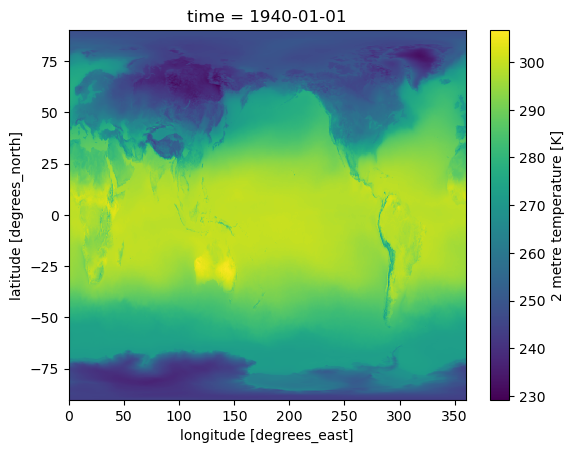

In [9]:
# dibujamos el primer mes
ds['t2m'].isel(time = 0).plot()

In [10]:
# lista de ficheros
files = np.sort(glob.glob(dest + 'ERA5/2m_temperature/' + '*.nc'))
# concatenamos todos los ficheros
ds_monthly = xr.open_mfdataset(files, 
                               concat_dim='time',
                               combine='nested',
                               chunks={'time': 1000})
# resampleamos a una agregacion anual
ds_annual = ds_monthly.resample(time = 'Y').mean(dim = 'time')
# cambiamos las longitudes de 0,360 a -180,180, ordenamos las latitudes y cambiamos el nombre de las coordenadas
ds_annual = standardization(ds_annual)
# cambiamos unidades (kelvin to degree C)
ds_annual['tas'] = ds_annual['tas'] - 273.15
ds_annual['tas'].attrs["units"] = "deg C"
# guardamos
#ds_annual.to_netcdf(dest + 'share' + '/' + 'tas_ERA5_yr_1940-2022.nc')

In [11]:
## Lo tengo ya resampleado para todo el periodo
tas_ERA5_yr = xr.open_dataset(dest + 'share' + '/' + 'tas_ERA5_yr_1940-2022.nc')

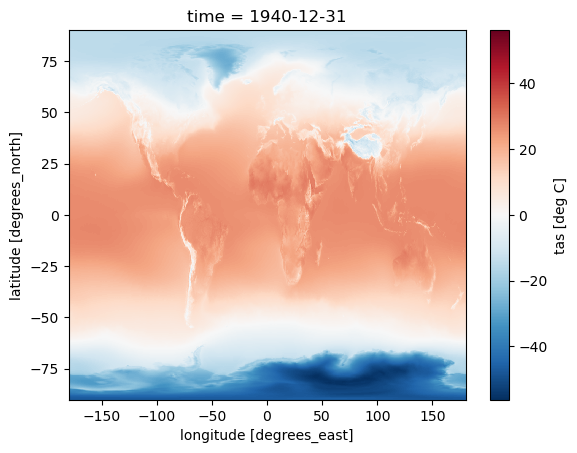

In [12]:
tas_ERA5_yr['tas'].isel(time=0).plot()

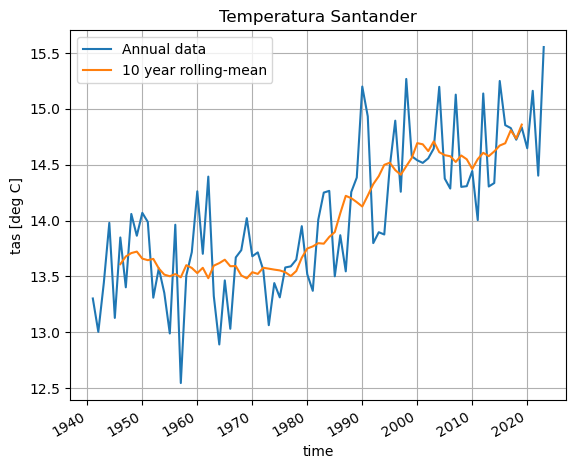

In [13]:
# Aumento de la temperatura para Santander
lat = 43.46 ; lon = -3.80;
tas_ERA5_yr['tas'].sel(lat = lat, lon = lon, method='nearest').plot(label = 'Annual data')
tas_ERA5_yr['tas'].sel(lat = lat, lon = lon, method='nearest').\
                            rolling(time = 10, center=True).mean().plot(label = '10 year rolling-mean')
plt.legend()
plt.title('Temperatura Santander')
plt.grid()

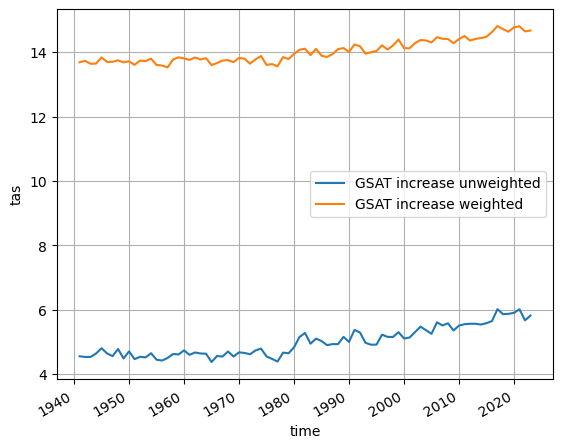

In [14]:
# Aumento de la temperatura global
tas_ERA5_yr_gbmean_unweighted = tas_ERA5_yr.mean(dim = ["lon", "lat"])
tas_ERA5_yr_gbmean_weighted = spatial_weighted_mean(tas_ERA5_yr)

tas_ERA5_yr_gbmean_unweighted['tas'].plot(label = "GSAT increase unweighted")
tas_ERA5_yr_gbmean_weighted['tas'].plot(label = "GSAT increase weighted")
plt.legend()
plt.grid()

# Validación de Modelos CORDEX en la Península Ibérica

Utilizamos las proyecciones climáticas oficiales del sexto informe del IPCC. El grupo de metorología de Santander (Santander Met. Group; https://github.com/SantanderMetGroup) las proporciona en su servidor [thredds](https://data.meteo.unican.es/thredds/)

Algo de información sobre la inciativa CORDEX: https://journals.ametsoc.org/view/journals/bams/103/12/BAMS-D-22-0111.1.xml

In [15]:
# seleccionamos ruta oPeNDAP
root = 'https://data.meteo.unican.es/thredds/dodsC/IPCC/AR6/IA-monthly/raw/CORDEX-EUR/'
root = os.getcwd() + '/data/share/' # tengo los ficheros guadados en local por si hubiera algún problema

In [16]:
file_hist_mon = 'CORDEX/historical/t_CORDEX-EUR_historical_mon_197001-200512.nc'
file_85_mon = 'CORDEX/rcp85/t_CORDEX-EUR_rcp85_mon_200601-210012.nc'

In [ ]:
# cargo ficheros
tas_hist_mon = xr.open_dataset(root + file_hist_mon, chunks = {'member':1})
tas_85_mon = xr.open_dataset(root + file_85_mon, chunks = {'member':1})

In [17]:
# cargo los datos a una resolcuión anual
tas_hist_yr = xr.open_dataset(root + file_hist_mon.replace('_mon_', '_yr_'), chunks = {'member':1})
tas_85_yr = xr.open_dataset(root + file_85_mon.replace('_mon_', '_yr_'), chunks = {'member':1})

In [18]:
## vemos los miembros
tas_hist_yr.member_id.values

array(['CNRM-CERFACS_CNRM-CM5_r1i1p1_CLMcom_CCLM4-8-17_v1',
       'CNRM-CERFACS_CNRM-CM5_r1i1p1_CNRM_ALADIN63_v2',
       'CNRM-CERFACS_CNRM-CM5_r1i1p1_DMI_HIRHAM5_v2',
       'CNRM-CERFACS_CNRM-CM5_r1i1p1_GERICS_REMO2015_v2',
       'CNRM-CERFACS_CNRM-CM5_r1i1p1_IPSL_WRF381P_v2',
       'CNRM-CERFACS_CNRM-CM5_r1i1p1_KNMI_RACMO22E_v2',
       'CNRM-CERFACS_CNRM-CM5_r1i1p1_RMIB-UGent_UGent-ALARO-0_v1',
       'CNRM-CERFACS_CNRM-CM5_r1i1p1_SMHI_RCA4_v1',
       'ICHEC_EC-EARTH_r12i1p1_CLMcom_CCLM4-8-17_v1',
       'ICHEC_EC-EARTH_r12i1p1_CLMcom_ETH-COSMO-crCLIM-v1-1_v1',
       'ICHEC_EC-EARTH_r12i1p1_DMI_HIRHAM5_v1',
       'ICHEC_EC-EARTH_r12i1p1_ICTP_RegCM4-6_v1',
       'ICHEC_EC-EARTH_r12i1p1_IPSL_WRF381P_v1',
       'ICHEC_EC-EARTH_r12i1p1_KNMI_RACMO22E_v1',
       'ICHEC_EC-EARTH_r12i1p1_SMHI_RCA4_v1',
       'ICHEC_EC-EARTH_r3i1p1_DMI_HIRHAM5_v2',
       'IPSL_IPSL-CM5A-MR_r1i1p1_DMI_HIRHAM5_v1',
       'IPSL_IPSL-CM5A-MR_r1i1p1_GERICS_REMO2015_v1',
       'IPSL_IPSL-CM5A-MR_r1i

- r = “realization”: experiments which differ only in random perturbations of the initial conditions of the experiment. Comparing different realizations allow estimation of the internal variability of the model climate.
- i = “initialization”: refers to variation in initialization parameters. Comparing differently initialized output provides an estimate of how sensitive the model is to initial conditions. 
- p = “physics”: refers to variations in the way in which sub-grid scale processes are represented. Comparing different simulations in this category provides an estimate of the structural uncertainty associated with choices in the model design.

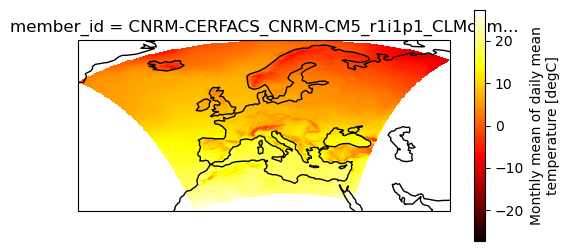

In [19]:
fig = plt.figure(figsize=(6, 3))
# set data projection
ax = plt.axes(projection=ccrs.PlateCarree())
# plot mean temperature over the entire period
tas_hist_yr['t'].isel(member = 0, time = 0).plot(cmap='hot')
# add coastline
ax.coastlines()

In [20]:
# Selecciono la Península Iberica
lat_iberia = slice(35.5, 44.5); lon_iberia = slice(-10,5.5)
# CORDEX
tas_hist_yr_iberian = tas_hist_yr.sel(lat=lat_iberia, lon=lon_iberia)
tas_85_yr_iberian = tas_85_yr.sel(lat=lat_iberia, lon=lon_iberia)
# ERA5
tas_ERA5_yr_iberian = tas_ERA5_yr.sel(lat=lat_iberia, lon=lon_iberia)

## Comparo el patrón espacial (1976-2005)

In [21]:
# seleciono el periodo 1979-2005
baseline = [1976, 2005]
# CORDEX
mask_baseline = tas_hist_yr_iberian.time.dt.year.isin(range(baseline[0], baseline[1]))
tas_hist_yr_iberian_baseline = tas_hist_yr_iberian.sel(time = mask_baseline)
# ERA5
mask_baseline = tas_ERA5_yr_iberian.time.dt.year.isin(range(baseline[0], baseline[1]))
tas_ERA5_yr_iberian_baseline = tas_ERA5_yr_iberian.sel(time = mask_baseline)

In [22]:
# cacula la media del ensemble de los modelos para ese periodo
tas_hist_yr_iberian_baseline_mean = tas_hist_yr_iberian_baseline.mean(dim = ["member", "time"])
tas_ERA5_yr_iberian_baseline_mean = tas_ERA5_yr_iberian_baseline.mean(dim = ["time"])

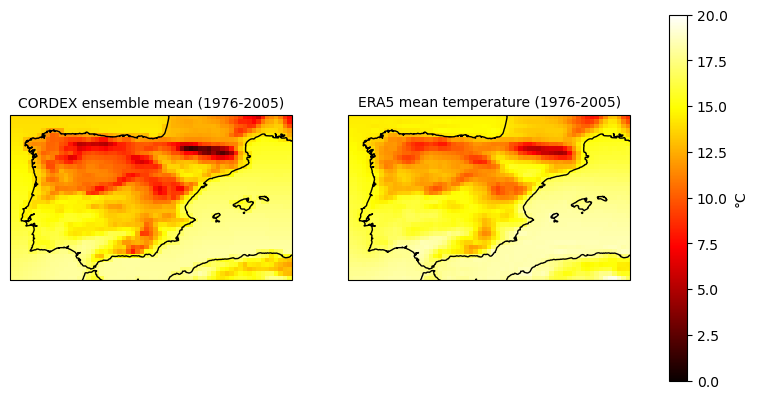

In [23]:
fig, ax = plt.subplots(1, 2, figsize = (10 ,5), subplot_kw={'projection': ccrs.PlateCarree()},
                       sharex=True, sharey=True)
m = tas_hist_yr_iberian_baseline_mean['t'].plot(ax = ax[0], cmap='hot', vmin = 0, vmax = 20, add_colorbar = False)
ax[0].set_title('CORDEX ensemble mean (1976-2005)', fontsize = 10)
ax[0].coastlines()
m = tas_ERA5_yr_iberian_baseline_mean['tas'].plot(ax = ax[1], cmap='hot', vmin = 0, vmax = 20, add_colorbar = False)
ax[1].set_title('ERA5 mean temperature (1976-2005)', fontsize = 10)
ax[1].coastlines()
cbar = fig.colorbar(m, ax=ax.ravel().tolist(), cmap = 'hot', label = '\u00b0C', shrink=0.95)

## Comparo las tendecias (1976-2005)

In [24]:
# Agrego espacialmente en la península Ibérica
# CORDEX
tas_hist_yr_iberian_mean = spatial_weighted_mean(tas_hist_yr_iberian)
tas_85_yr_iberian_mean = spatial_weighted_mean(tas_85_yr_iberian)
# ERA5
tas_ERA5_yr_iberian_mean = spatial_weighted_mean(tas_ERA5_yr_iberian)

In [25]:
tas_yr_iberian_mean = xr.concat([tas_hist_yr_iberian_mean, tas_85_yr_iberian_mean], dim = 'time')

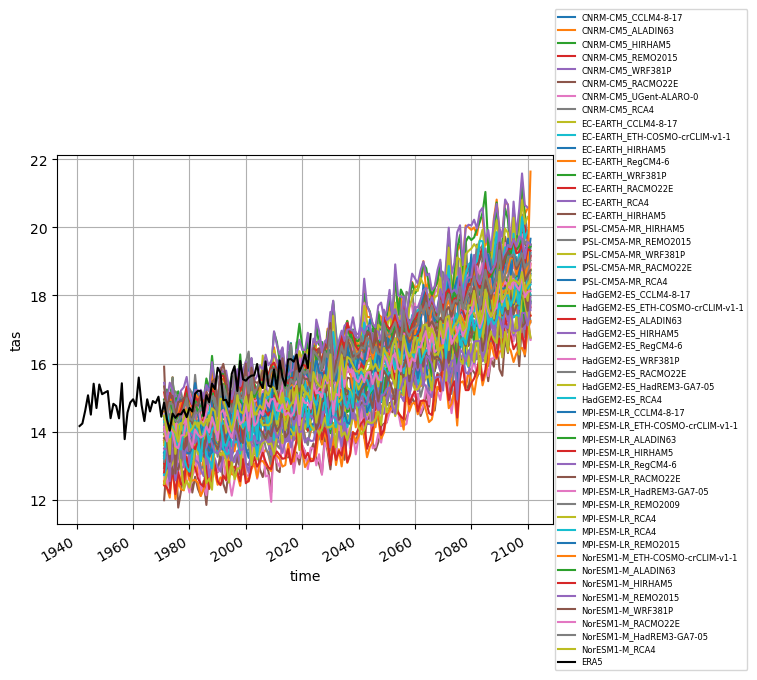

In [26]:
p = tas_yr_iberian_mean['t'].plot.line(x = 'time', 
                                       label = tas_yr_iberian_mean.gcm_model.values + '_' +
                                               tas_yr_iberian_mean.rcm_model.values)
tas_ERA5_yr_iberian_mean['tas'].plot.line(label = 'ERA5', color = 'k')
plt.legend(loc='right', fontsize = 6, bbox_to_anchor=(1.4, 0.5))
plt.grid()

In [27]:
# Calculo la media en un periodo baseline y se la quito a los modelos para trabajar con anomalias
baseline = [1976, 2005]
mask_baseline_CORDEX = tas_yr_iberian_mean.time.dt.year.isin(range(baseline[0], baseline[1]))
tas_yr_iberian_mean_baseline = tas_yr_iberian_mean.sel(time=mask_baseline_CORDEX).mean(dim = 'time')
mask_baseline_ERA5 = tas_ERA5_yr_iberian_mean.time.dt.year.isin(range(baseline[0], baseline[1]))
tas_ERA5_yr_iberian_mean_baseline = tas_ERA5_yr_iberian_mean.sel(time=mask_baseline_ERA5).mean(dim = 'time')

In [28]:
tas_yr_iberian_mean_anom = tas_yr_iberian_mean - tas_yr_iberian_mean_baseline
tas_ERA5_yr_iberian_mean_anom = tas_ERA5_yr_iberian_mean - tas_ERA5_yr_iberian_mean_baseline

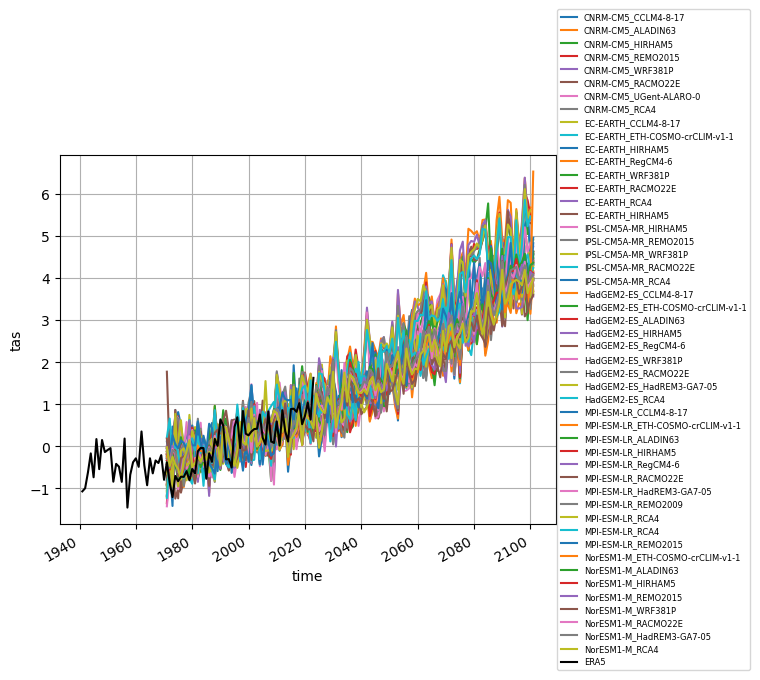

In [29]:
p = tas_yr_iberian_mean_anom['t'].plot.line(x = 'time', 
                                       label = tas_yr_iberian_mean.gcm_model.values + '_' +
                                               tas_yr_iberian_mean.rcm_model.values)
tas_ERA5_yr_iberian_mean_anom['tas'].plot.line(label = 'ERA5', color = 'k')
plt.legend(loc='right', fontsize = 6, bbox_to_anchor=(1.4, 0.5))
plt.grid()

In [30]:
da = tas_ERA5_yr_iberian_mean.sel(time=mask_baseline_ERA5).copy()

x = np.arange(da.time.shape[0]) 

stats_ERA5 = xr.apply_ufunc(slope, da, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       output_sizes={"parameter": 5},)

/tmp/ipykernel_147067/1429008649.py:5: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stats_ERA5 = xr.apply_ufunc(slope, da,


In [31]:
da = tas_yr_iberian_mean_anom.sel(time=mask_baseline_CORDEX)

x = np.arange(da.time.shape[0]) 

stats_CORDEX = xr.apply_ufunc(slope, da, 
                       input_core_dims=[['time']],
                       output_core_dims=[["parameter"]],
                       vectorize=True,
                       dask="parallelized",
                       output_dtypes=['float64'],
                       output_sizes={"parameter": 5},)

/tmp/ipykernel_147067/4016840039.py:5: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  stats_CORDEX = xr.apply_ufunc(slope, da,


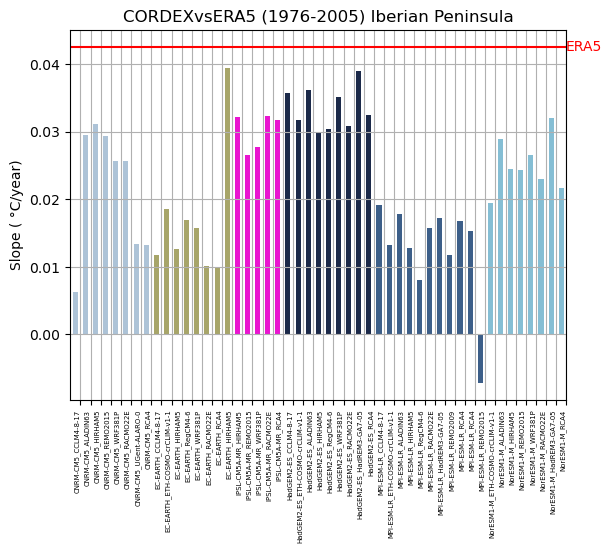

In [32]:
slope_series = stats_CORDEX['t'].to_series()

fig, ax = plt.subplots()

a = slope_series[:,0].plot.bar(ylabel = 'Slope ( \u00b0C/year)',
                          xlabel = '', ax = ax, color = random_color_string(da.gcm_model.values))
b = ax.set_xticks(np.arange(len(da.gcm_model.values))+0.5)
b = ax.set_xticklabels(da.gcm_model.values + '_' +
                       da.rcm_model.values, 
                       rotation=90, ha='right', size = 5)
plt.axhline(y = stats_ERA5['tas'][0], color = 'r', linestyle = '-')
plt.text(len(da.gcm_model.values)+1.2, stats_ERA5['tas'][0], 'ERA5', 
         fontsize=10, va='center', ha='center', color = 'red')

plt.title('CORDEXvsERA5 (1976-2005) Iberian Peninsula')
plt.grid()

Una de las posibles causes de este desacuerdo es que la mayoría de modelos CORDEX no tratan los aerosoles de manera dinámica (la nueva generación de modelos conducidos por CMIP6 si que lo hacen). Esto hace que no sea capaces de capturan el aumento en la tase de calentamiento que se ha producido en las últimas décadas del periodo histórico como consecuencia de la reducción en la emisión y concentración de los mismos:https://journals.ametsoc.org/view/journals/clim/35/24/JCLI-D-22-0081.1.xml?tab_body=pdf